# 03 - Treinamento do Modelo LSTM
## Tech Challenge Fase 4 - Previsão de Ações com LSTM

Este notebook demonstra o treinamento do modelo LSTM para previsão de preços de ações.

In [1]:
import sys
sys.path.append('..')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from src.models.lstm_model import StockLSTM

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Configurações do Modelo

In [2]:
# Hiperparâmetros
LSTM_UNITS = [128, 64, 32]
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 10

print("Configurações do Modelo:")
print(f"  LSTM Units: {LSTM_UNITS}")
print(f"  Dropout: {DROPOUT_RATE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Early Stopping Patience: {PATIENCE}")

Configurações do Modelo:
  LSTM Units: [128, 64, 32]
  Dropout: 0.2
  Learning Rate: 0.001
  Batch Size: 32
  Max Epochs: 100
  Early Stopping Patience: 10


## 2. Carregar Dados Preprocessados

In [3]:
# Carregar dados
X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

# Carregar scaler
with open('../data/processed/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("Dados carregados com sucesso!")
print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Dados carregados com sucesso!

X_train: (570, 60, 5)
y_train: (570,)
X_test: (143, 60, 5)
y_test: (143,)


## 3. Construir Arquitetura do Modelo

In [4]:
# Usar a classe StockLSTM
input_shape = (X_train.shape[1], X_train.shape[2])
stock_lstm = StockLSTM(input_shape=input_shape, units=LSTM_UNITS)
model = stock_lstm.build_model()

print("Modelo construído!")
print(f"\nInput Shape: {input_shape}")
model.summary()

2025-11-04 19:39:09.835656: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/laylindo/Documents/FIAP/MLE/4A FASE/tech-challenge-4/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo construído!

Input Shape: (60, 5)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,179 (516.32 KB)

 Trainable params: 131,731 (514.57 KB)

 Non-trainable params: 448 (1.75 KB)

## 4. Configurar Callbacks

In [5]:
# Criar diretório para checkpoints
os.makedirs('../models/checkpoints', exist_ok=True)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
checkpoint = ModelCheckpoint(
    '../models/checkpoints/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("Callbacks configurados:")
print("  ✅ Early Stopping")
print("  ✅ Learning Rate Reduction")
print("  ✅ Model Checkpoint")

Callbacks configurados:
  ✅ Early Stopping
  ✅ Learning Rate Reduction
  ✅ Model Checkpoint


## 5. Treinar Modelo

In [6]:
print("🏋️ Iniciando treinamento...\n")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Treinamento concluído!")

🏋️ Iniciando treinamento...



Epoch 1/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 3:59 14s/step - loss: 0.3914 - mae: 0.5225

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.3938 - mae: 0.5181

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.3991 - mae: 0.5163

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.4075 - mae: 0.5196

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.4146 - mae: 0.5215

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.4163 - mae: 0.5216

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.4176 - mae: 0.5213

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.4209 - mae: 0.5224

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.4219 - mae: 0.5219

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.4211 - mae: 0.5205

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.4192 - mae: 0.5185

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.4170 - mae: 0.5165

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.4148 - mae: 0.5147

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.4123 - mae: 0.5130

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.4095 - mae: 0.5108

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.4063 - mae: 0.5084

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.4027 - mae: 0.5057

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.3992 - mae: 0.5030


Epoch 1: val_loss improved from None to 0.57772, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - loss: 0.3392 - mae: 0.4571 - val_loss: 0.5777 - val_mae: 0.7543 - learning_rate: 0.0010


Epoch 2/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.3631 - mae: 0.4450

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 0.3403 - mae: 0.4418

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.3142 - mae: 0.4266

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.2960 - mae: 0.4150

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.2831 - mae: 0.4060

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.2716 - mae: 0.3975

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.2637 - mae: 0.3923

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.2561 - mae: 0.3870

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.2490 - mae: 0.3818

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.2426 - mae: 0.3772

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.2372 - mae: 0.3733

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.2320 - mae: 0.3695

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.2274 - mae: 0.3659

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.2231 - mae: 0.3624

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.2191 - mae: 0.3593

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.2156 - mae: 0.3565

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.2123 - mae: 0.3538

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.2093 - mae: 0.3515


Epoch 2: val_loss improved from 0.57772 to 0.47253, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - loss: 0.1591 - mae: 0.3125 - val_loss: 0.4725 - val_mae: 0.6812 - learning_rate: 0.0010


Epoch 3/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 9s 551ms/step - loss: 0.0546 - mae: 0.1767

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.0708 - mae: 0.1998

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0796 - mae: 0.2138

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0835 - mae: 0.2221

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0875 - mae: 0.2288

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0905 - mae: 0.2333

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0922 - mae: 0.2360

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0929 - mae: 0.2374

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0932 - mae: 0.2381

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0943 - mae: 0.2397

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0948 - mae: 0.2406

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0951 - mae: 0.2412

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0952 - mae: 0.2417

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0955 - mae: 0.2423

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0957 - mae: 0.2426

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0958 - mae: 0.2429

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0958 - mae: 0.2430

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0958 - mae: 0.2431


Epoch 3: val_loss improved from 0.47253 to 0.41795, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 0.0959 - mae: 0.2452 - val_loss: 0.4180 - val_mae: 0.6401 - learning_rate: 0.0010


Epoch 4/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 0.1008 - mae: 0.2582

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0959 - mae: 0.2495

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0948 - mae: 0.2472

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0943 - mae: 0.2440

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0925 - mae: 0.2399

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 0.0902 - mae: 0.2353

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - loss: 0.0887 - mae: 0.2327

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0878 - mae: 0.2313

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0872 - mae: 0.2307

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0865 - mae: 0.2297

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0862 - mae: 0.2293

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0857 - mae: 0.2286

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0851 - mae: 0.2278

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0846 - mae: 0.2271

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0840 - mae: 0.2264

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0835 - mae: 0.2257

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0830 - mae: 0.2251

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0825 - mae: 0.2246


Epoch 4: val_loss improved from 0.41795 to 0.37637, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - loss: 0.0747 - mae: 0.2156 - val_loss: 0.3764 - val_mae: 0.6071 - learning_rate: 0.0010


Epoch 5/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step - loss: 0.0780 - mae: 0.2340

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0797 - mae: 0.2338

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0756 - mae: 0.2264

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0743 - mae: 0.2230

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0736 - mae: 0.2206

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0736 - mae: 0.2190

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0732 - mae: 0.2173

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0735 - mae: 0.2162

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0736 - mae: 0.2152

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0735 - mae: 0.2141

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0736 - mae: 0.2135

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0735 - mae: 0.2128

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0734 - mae: 0.2122

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0733 - mae: 0.2117

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0731 - mae: 0.2114

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0729 - mae: 0.2109

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0726 - mae: 0.2104

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0724 - mae: 0.2099


Epoch 5: val_loss improved from 0.37637 to 0.32642, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 0.0677 - mae: 0.2018 - val_loss: 0.3264 - val_mae: 0.5640 - learning_rate: 0.0010


Epoch 6/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 0.0534 - mae: 0.1941

 2/18 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - loss: 0.0577 - mae: 0.1949

 3/18 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - loss: 0.0584 - mae: 0.1947

 4/18 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - loss: 0.0584 - mae: 0.1938

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.0579 - mae: 0.1926

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0577 - mae: 0.1916

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0575 - mae: 0.1907

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0574 - mae: 0.1901

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0573 - mae: 0.1898

10/18 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.0574 - mae: 0.1899

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0576 - mae: 0.1900

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0575 - mae: 0.1898

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0573 - mae: 0.1894

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0573 - mae: 0.1893

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0571 - mae: 0.1891

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0570 - mae: 0.1888

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0568 - mae: 0.1884

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0566 - mae: 0.1880


Epoch 6: val_loss improved from 0.32642 to 0.31887, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - loss: 0.0538 - mae: 0.1820 - val_loss: 0.3189 - val_mae: 0.5569 - learning_rate: 0.0010


Epoch 7/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 0.0325 - mae: 0.1436

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 0.0383 - mae: 0.1554

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0429 - mae: 0.1655

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0443 - mae: 0.1690

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0449 - mae: 0.1704

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.0454 - mae: 0.1714

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.0458 - mae: 0.1725

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0457 - mae: 0.1726

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0459 - mae: 0.1730

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0462 - mae: 0.1735

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0466 - mae: 0.1741

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0469 - mae: 0.1746

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0471 - mae: 0.1749

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0473 - mae: 0.1752

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0475 - mae: 0.1756

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0476 - mae: 0.1757

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0476 - mae: 0.1757

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0476 - mae: 0.1757


Epoch 7: val_loss improved from 0.31887 to 0.31369, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - loss: 0.0472 - mae: 0.1751 - val_loss: 0.3137 - val_mae: 0.5518 - learning_rate: 0.0010


Epoch 8/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 0.0410 - mae: 0.1639

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0445 - mae: 0.1714

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0430 - mae: 0.1683

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0428 - mae: 0.1682

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0425 - mae: 0.1674

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - loss: 0.0426 - mae: 0.1675

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0425 - mae: 0.1675

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0425 - mae: 0.1673

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0425 - mae: 0.1671

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0425 - mae: 0.1669

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0424 - mae: 0.1668

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0423 - mae: 0.1664

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0422 - mae: 0.1662

14/18 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0422 - mae: 0.1660

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0422 - mae: 0.1660

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0421 - mae: 0.1659

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0420 - mae: 0.1657

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0419 - mae: 0.1656


Epoch 8: val_loss improved from 0.31369 to 0.25969, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - loss: 0.0402 - mae: 0.1625 - val_loss: 0.2597 - val_mae: 0.5007 - learning_rate: 0.0010


Epoch 9/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - loss: 0.0379 - mae: 0.1635

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0401 - mae: 0.1667

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 0.0436 - mae: 0.1694

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0455 - mae: 0.1715

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0456 - mae: 0.1711

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0458 - mae: 0.1706

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0458 - mae: 0.1701

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0458 - mae: 0.1698

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0457 - mae: 0.1692

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0456 - mae: 0.1689

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0455 - mae: 0.1685

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0453 - mae: 0.1682

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0452 - mae: 0.1677

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0450 - mae: 0.1673

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0448 - mae: 0.1668

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0446 - mae: 0.1665

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0445 - mae: 0.1663

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0445 - mae: 0.1662


Epoch 9: val_loss did not improve from 0.25969


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.0435 - mae: 0.1644 - val_loss: 0.2653 - val_mae: 0.5065 - learning_rate: 0.0010


Epoch 10/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.0303 - mae: 0.1449

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - loss: 0.0318 - mae: 0.1488

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0316 - mae: 0.1472

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0319 - mae: 0.1469

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0317 - mae: 0.1461

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0319 - mae: 0.1461

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0325 - mae: 0.1469

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.0331 - mae: 0.1480

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.0334 - mae: 0.1486

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0336 - mae: 0.1485

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0337 - mae: 0.1483

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0338 - mae: 0.1484

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0339 - mae: 0.1483

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0339 - mae: 0.1484

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0339 - mae: 0.1483

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0340 - mae: 0.1483

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0340 - mae: 0.1482

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0340 - mae: 0.1482


Epoch 10: val_loss improved from 0.25969 to 0.24224, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.0343 - mae: 0.1484 - val_loss: 0.2422 - val_mae: 0.4841 - learning_rate: 0.0010


Epoch 11/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - loss: 0.0330 - mae: 0.1431

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - loss: 0.0292 - mae: 0.1332

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0280 - mae: 0.1311

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0281 - mae: 0.1315

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.0287 - mae: 0.1332

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0292 - mae: 0.1346

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0296 - mae: 0.1357

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0300 - mae: 0.1369

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0303 - mae: 0.1378

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0305 - mae: 0.1385

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0308 - mae: 0.1392

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0310 - mae: 0.1398

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0312 - mae: 0.1403

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0313 - mae: 0.1407

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0314 - mae: 0.1410

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0315 - mae: 0.1412

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0316 - mae: 0.1415

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0317 - mae: 0.1417


Epoch 11: val_loss did not improve from 0.24224


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - loss: 0.0326 - mae: 0.1449 - val_loss: 0.2457 - val_mae: 0.4875 - learning_rate: 0.0010


Epoch 12/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - loss: 0.0277 - mae: 0.1426

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0296 - mae: 0.1435

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.0297 - mae: 0.1418

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0306 - mae: 0.1431

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0314 - mae: 0.1444

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0319 - mae: 0.1447

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - loss: 0.0319 - mae: 0.1441

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0317 - mae: 0.1433

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.0315 - mae: 0.1427

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0313 - mae: 0.1421

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0312 - mae: 0.1418

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0311 - mae: 0.1415

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0310 - mae: 0.1413

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0310 - mae: 0.1413

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0310 - mae: 0.1412

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0310 - mae: 0.1413

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0311 - mae: 0.1414

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0311 - mae: 0.1414


Epoch 12: val_loss did not improve from 0.24224


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - loss: 0.0311 - mae: 0.1414 - val_loss: 0.2507 - val_mae: 0.4928 - learning_rate: 0.0010


Epoch 13/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 11s 678ms/step - loss: 0.0337 - mae: 0.1443

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.0312 - mae: 0.1372 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0291 - mae: 0.1318

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0283 - mae: 0.1302

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0279 - mae: 0.1298

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0280 - mae: 0.1307

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0279 - mae: 0.1310

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0279 - mae: 0.1314

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0279 - mae: 0.1317

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0277 - mae: 0.1315

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0275 - mae: 0.1313

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0276 - mae: 0.1315

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0276 - mae: 0.1317

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0276 - mae: 0.1318

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0277 - mae: 0.1321

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0277 - mae: 0.1323

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0277 - mae: 0.1324

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0278 - mae: 0.1326


Epoch 13: val_loss improved from 0.24224 to 0.19371, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - loss: 0.0286 - mae: 0.1350 - val_loss: 0.1937 - val_mae: 0.4312 - learning_rate: 0.0010


Epoch 14/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0189 - mae: 0.1134

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 0.0213 - mae: 0.1187

 3/18 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0240 - mae: 0.1229

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.0250 - mae: 0.1243

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0252 - mae: 0.1246

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0254 - mae: 0.1251

 7/18 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.0256 - mae: 0.1252

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0256 - mae: 0.1252

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.0256 - mae: 0.1254

10/18 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.0255 - mae: 0.1252

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.0255 - mae: 0.1252

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 0.0254 - mae: 0.1251

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0254 - mae: 0.1252

14/18 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0254 - mae: 0.1253

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0254 - mae: 0.1254

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0254 - mae: 0.1255

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0254 - mae: 0.1257

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0254 - mae: 0.1258


Epoch 14: val_loss did not improve from 0.19371


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - loss: 0.0257 - mae: 0.1277 - val_loss: 0.2103 - val_mae: 0.4495 - learning_rate: 0.0010


Epoch 15/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 0.0238 - mae: 0.1257

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - loss: 0.0249 - mae: 0.1293

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0249 - mae: 0.1288

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0249 - mae: 0.1288

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0250 - mae: 0.1284

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0248 - mae: 0.1278

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0248 - mae: 0.1278

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0246 - mae: 0.1274

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0245 - mae: 0.1269

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0244 - mae: 0.1265

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0243 - mae: 0.1262

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0242 - mae: 0.1258

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0241 - mae: 0.1255

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0241 - mae: 0.1255

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0241 - mae: 0.1254

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0241 - mae: 0.1254

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0240 - mae: 0.1252

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0240 - mae: 0.1251


Epoch 15: val_loss improved from 0.19371 to 0.16534, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - loss: 0.0232 - mae: 0.1231 - val_loss: 0.1653 - val_mae: 0.3963 - learning_rate: 0.0010


Epoch 16/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 0.0153 - mae: 0.0996

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.0165 - mae: 0.1050

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0180 - mae: 0.1091

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0186 - mae: 0.1107

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0190 - mae: 0.1116

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.0191 - mae: 0.1120

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.0195 - mae: 0.1129

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0198 - mae: 0.1136

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0201 - mae: 0.1141

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0202 - mae: 0.1143

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0202 - mae: 0.1143

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0204 - mae: 0.1147

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0205 - mae: 0.1149

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0207 - mae: 0.1152

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0208 - mae: 0.1155

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0210 - mae: 0.1159

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0212 - mae: 0.1162

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0213 - mae: 0.1164


Epoch 16: val_loss improved from 0.16534 to 0.15046, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - loss: 0.0229 - mae: 0.1201 - val_loss: 0.1505 - val_mae: 0.3772 - learning_rate: 0.0010


Epoch 17/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - loss: 0.0189 - mae: 0.1064

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0187 - mae: 0.1081

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0183 - mae: 0.1070

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.0180 - mae: 0.1063

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0180 - mae: 0.1065

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.0181 - mae: 0.1069

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - loss: 0.0185 - mae: 0.1075

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0189 - mae: 0.1083

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0193 - mae: 0.1090

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0196 - mae: 0.1097

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0197 - mae: 0.1102

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0199 - mae: 0.1106

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0201 - mae: 0.1111

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0203 - mae: 0.1116

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0204 - mae: 0.1119

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0205 - mae: 0.1121

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0206 - mae: 0.1123

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0206 - mae: 0.1124


Epoch 17: val_loss did not improve from 0.15046


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - loss: 0.0216 - mae: 0.1155 - val_loss: 0.1595 - val_mae: 0.3899 - learning_rate: 0.0010


Epoch 18/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 0.0244 - mae: 0.1328

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.0219 - mae: 0.1228

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0229 - mae: 0.1227

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0226 - mae: 0.1213

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0221 - mae: 0.1192

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0218 - mae: 0.1180

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0214 - mae: 0.1165

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0212 - mae: 0.1156

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0209 - mae: 0.1147

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0208 - mae: 0.1143

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.0206 - mae: 0.1138

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0204 - mae: 0.1133

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0203 - mae: 0.1130

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0203 - mae: 0.1128

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0202 - mae: 0.1127

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0203 - mae: 0.1127

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0203 - mae: 0.1128

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0204 - mae: 0.1129


Epoch 18: val_loss did not improve from 0.15046


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0210 - mae: 0.1143 - val_loss: 0.1579 - val_mae: 0.3882 - learning_rate: 0.0010


Epoch 19/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0255 - mae: 0.1263

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0255 - mae: 0.1295

 3/18 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - loss: 0.0247 - mae: 0.1280

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 0.0244 - mae: 0.1270

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0240 - mae: 0.1258

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0237 - mae: 0.1244

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0235 - mae: 0.1238

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0234 - mae: 0.1232

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0232 - mae: 0.1227

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0231 - mae: 0.1223

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0229 - mae: 0.1219

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0228 - mae: 0.1216

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0227 - mae: 0.1213

14/18 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0226 - mae: 0.1210

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0225 - mae: 0.1207

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0224 - mae: 0.1205

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0223 - mae: 0.1203

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0223 - mae: 0.1203


Epoch 19: val_loss improved from 0.15046 to 0.12994, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - loss: 0.0218 - mae: 0.1197 - val_loss: 0.1299 - val_mae: 0.3492 - learning_rate: 0.0010


Epoch 20/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - loss: 0.0238 - mae: 0.1273

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.0244 - mae: 0.1285

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0246 - mae: 0.1286

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 0.0246 - mae: 0.1290

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 0.0241 - mae: 0.1273

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.0236 - mae: 0.1257

 7/18 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - loss: 0.0236 - mae: 0.1254

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.0235 - mae: 0.1247

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0234 - mae: 0.1242

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0232 - mae: 0.1234

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0231 - mae: 0.1229

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0229 - mae: 0.1224

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0228 - mae: 0.1219

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0227 - mae: 0.1216

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0226 - mae: 0.1213

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0225 - mae: 0.1209

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0224 - mae: 0.1205

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0223 - mae: 0.1200


Epoch 20: val_loss improved from 0.12994 to 0.11417, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.0202 - mae: 0.1129 - val_loss: 0.1142 - val_mae: 0.3260 - learning_rate: 0.0010


Epoch 21/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 0.0162 - mae: 0.1041

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0173 - mae: 0.1060

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0174 - mae: 0.1064

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0171 - mae: 0.1047

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0170 - mae: 0.1039

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0168 - mae: 0.1035

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0167 - mae: 0.1032

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0166 - mae: 0.1029

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0167 - mae: 0.1029

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0167 - mae: 0.1029

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0166 - mae: 0.1029

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.0167 - mae: 0.1031

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0167 - mae: 0.1033

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0168 - mae: 0.1035

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0168 - mae: 0.1036

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0168 - mae: 0.1037

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0169 - mae: 0.1038

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0169 - mae: 0.1039


Epoch 21: val_loss did not improve from 0.11417


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0177 - mae: 0.1057 - val_loss: 0.1335 - val_mae: 0.3547 - learning_rate: 0.0010


Epoch 22/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - loss: 0.0128 - mae: 0.0891

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.0140 - mae: 0.0904

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0151 - mae: 0.0942

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0156 - mae: 0.0960

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0157 - mae: 0.0968

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.0158 - mae: 0.0973

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0158 - mae: 0.0976

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0158 - mae: 0.0977

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.0158 - mae: 0.0979

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.0160 - mae: 0.0985

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0160 - mae: 0.0988

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.0161 - mae: 0.0991

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0162 - mae: 0.0995

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0163 - mae: 0.0998

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0164 - mae: 0.1002

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0165 - mae: 0.1006

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0166 - mae: 0.1008

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0166 - mae: 0.1010


Epoch 22: val_loss did not improve from 0.11417


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0174 - mae: 0.1043 - val_loss: 0.1189 - val_mae: 0.3341 - learning_rate: 0.0010


Epoch 23/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0169 - mae: 0.0989

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0160 - mae: 0.0966

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0159 - mae: 0.0967

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0158 - mae: 0.0966

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0155 - mae: 0.0961

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0158 - mae: 0.0968

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0159 - mae: 0.0971

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0159 - mae: 0.0970

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0159 - mae: 0.0969

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0159 - mae: 0.0969

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0159 - mae: 0.0971

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0160 - mae: 0.0972

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0160 - mae: 0.0974

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0160 - mae: 0.0976

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0160 - mae: 0.0976

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0160 - mae: 0.0977

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0160 - mae: 0.0976

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0160 - mae: 0.0976


Epoch 23: val_loss did not improve from 0.11417


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0158 - mae: 0.0978 - val_loss: 0.1194 - val_mae: 0.3350 - learning_rate: 0.0010


Epoch 24/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0131 - mae: 0.0984

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0136 - mae: 0.0988

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0139 - mae: 0.0986

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0140 - mae: 0.0976

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.0144 - mae: 0.0980

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0150 - mae: 0.0990

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0152 - mae: 0.0995

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0154 - mae: 0.0996

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0154 - mae: 0.0995

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.0153 - mae: 0.0990

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0154 - mae: 0.0990

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.0155 - mae: 0.0990

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0155 - mae: 0.0990

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0156 - mae: 0.0991

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0157 - mae: 0.0992

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0157 - mae: 0.0993

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0158 - mae: 0.0995

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0159 - mae: 0.0997


Epoch 24: val_loss did not improve from 0.11417


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0168 - mae: 0.1024 - val_loss: 0.1331 - val_mae: 0.3554 - learning_rate: 0.0010


Epoch 25/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0161 - mae: 0.0975

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0148 - mae: 0.0937

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.0147 - mae: 0.0933

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0150 - mae: 0.0945

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0150 - mae: 0.0949

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0148 - mae: 0.0945

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0146 - mae: 0.0941

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0145 - mae: 0.0938

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0143 - mae: 0.0934

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0142 - mae: 0.0931

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0141 - mae: 0.0928

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0140 - mae: 0.0926

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0139 - mae: 0.0923

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0139 - mae: 0.0922

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0138 - mae: 0.0920

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0138 - mae: 0.0918

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0137 - mae: 0.0917

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0137 - mae: 0.0917


Epoch 25: val_loss improved from 0.11417 to 0.08594, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 0.0135 - mae: 0.0913 - val_loss: 0.0859 - val_mae: 0.2818 - learning_rate: 0.0010


Epoch 26/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0151 - mae: 0.0994

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 0.0155 - mae: 0.0989

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0158 - mae: 0.0991

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0160 - mae: 0.0996

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0159 - mae: 0.0994

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0160 - mae: 0.0996

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0163 - mae: 0.1006

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.0164 - mae: 0.1010

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0164 - mae: 0.1011

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0164 - mae: 0.1012

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0163 - mae: 0.1010

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0162 - mae: 0.1008

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0161 - mae: 0.1007

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0161 - mae: 0.1005

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0160 - mae: 0.1004

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0160 - mae: 0.1002

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0159 - mae: 0.1001

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0159 - mae: 0.0999


Epoch 26: val_loss did not improve from 0.08594


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 0.0148 - mae: 0.0971 - val_loss: 0.1141 - val_mae: 0.3284 - learning_rate: 0.0010


Epoch 27/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0119 - mae: 0.0875

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0115 - mae: 0.0852

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0115 - mae: 0.0850

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0117 - mae: 0.0853

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0121 - mae: 0.0866

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0124 - mae: 0.0874

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0125 - mae: 0.0876

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0129 - mae: 0.0886

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0132 - mae: 0.0894

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0135 - mae: 0.0901

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0137 - mae: 0.0907

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.0138 - mae: 0.0912

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0140 - mae: 0.0917

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0141 - mae: 0.0920

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0142 - mae: 0.0923

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0142 - mae: 0.0925

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0143 - mae: 0.0926

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0143 - mae: 0.0928


Epoch 27: val_loss improved from 0.08594 to 0.07273, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0152 - mae: 0.0958 - val_loss: 0.0727 - val_mae: 0.2584 - learning_rate: 0.0010


Epoch 28/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0089 - mae: 0.0687

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.0096 - mae: 0.0736

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0105 - mae: 0.0786

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0108 - mae: 0.0809

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0114 - mae: 0.0829

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0118 - mae: 0.0840

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0120 - mae: 0.0848

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0122 - mae: 0.0852

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0123 - mae: 0.0856

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0124 - mae: 0.0860

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0124 - mae: 0.0864

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0125 - mae: 0.0866

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0125 - mae: 0.0868

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0125 - mae: 0.0870

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0125 - mae: 0.0871

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0125 - mae: 0.0872

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0125 - mae: 0.0872

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0125 - mae: 0.0873


Epoch 28: val_loss did not improve from 0.07273


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 0.0125 - mae: 0.0887 - val_loss: 0.0900 - val_mae: 0.2892 - learning_rate: 0.0010


Epoch 29/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0049 - mae: 0.0561

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 0.0078 - mae: 0.0660

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.0087 - mae: 0.0688

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0094 - mae: 0.0713

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0098 - mae: 0.0733

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0102 - mae: 0.0751

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0105 - mae: 0.0768

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0109 - mae: 0.0784

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0110 - mae: 0.0793

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0112 - mae: 0.0800

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0112 - mae: 0.0805

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.0113 - mae: 0.0809

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0114 - mae: 0.0815

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0115 - mae: 0.0820

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0116 - mae: 0.0823

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0116 - mae: 0.0827

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0117 - mae: 0.0829

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0117 - mae: 0.0830


Epoch 29: val_loss did not improve from 0.07273


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.0119 - mae: 0.0847 - val_loss: 0.1083 - val_mae: 0.3188 - learning_rate: 0.0010


Epoch 30/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0136 - mae: 0.0936

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0136 - mae: 0.0945

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.0130 - mae: 0.0920

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0128 - mae: 0.0910

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.0127 - mae: 0.0903

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0127 - mae: 0.0900

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0126 - mae: 0.0895

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0125 - mae: 0.0889

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0125 - mae: 0.0885

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0124 - mae: 0.0880

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0123 - mae: 0.0876

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0123 - mae: 0.0873

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0122 - mae: 0.0870

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0122 - mae: 0.0868

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0122 - mae: 0.0867

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0121 - mae: 0.0865

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0121 - mae: 0.0863

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0121 - mae: 0.0863


Epoch 30: val_loss improved from 0.07273 to 0.05978, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.0120 - mae: 0.0852 - val_loss: 0.0598 - val_mae: 0.2312 - learning_rate: 0.0010


Epoch 31/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 10s 647ms/step - loss: 0.0108 - mae: 0.0870

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.0120 - mae: 0.0912 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0121 - mae: 0.0907

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0129 - mae: 0.0915

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0132 - mae: 0.0917

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0134 - mae: 0.0917

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0135 - mae: 0.0914

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0136 - mae: 0.0910

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0136 - mae: 0.0907

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0137 - mae: 0.0909

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0137 - mae: 0.0910

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0138 - mae: 0.0909

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.0137 - mae: 0.0908

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0137 - mae: 0.0908

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0137 - mae: 0.0906

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0137 - mae: 0.0905

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0137 - mae: 0.0905

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0137 - mae: 0.0905


Epoch 31: val_loss did not improve from 0.05978


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - loss: 0.0138 - mae: 0.0907 - val_loss: 0.0779 - val_mae: 0.2684 - learning_rate: 0.0010


Epoch 32/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0086 - mae: 0.0752

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0092 - mae: 0.0784

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0092 - mae: 0.0791

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0094 - mae: 0.0803

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0098 - mae: 0.0812

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0103 - mae: 0.0825

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.0107 - mae: 0.0838

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.0111 - mae: 0.0849

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0113 - mae: 0.0858

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0116 - mae: 0.0866

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0118 - mae: 0.0871

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0118 - mae: 0.0872

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0119 - mae: 0.0874

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0120 - mae: 0.0876

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0121 - mae: 0.0877

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0121 - mae: 0.0879

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0122 - mae: 0.0881

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0122 - mae: 0.0882


Epoch 32: val_loss did not improve from 0.05978


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0134 - mae: 0.0914 - val_loss: 0.0775 - val_mae: 0.2671 - learning_rate: 0.0010


Epoch 33/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0134 - mae: 0.1032

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0122 - mae: 0.0968

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0122 - mae: 0.0951

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0123 - mae: 0.0945

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0122 - mae: 0.0937

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0124 - mae: 0.0936

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0126 - mae: 0.0940

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.0127 - mae: 0.0942

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0129 - mae: 0.0945

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0130 - mae: 0.0946

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0131 - mae: 0.0946

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0131 - mae: 0.0945

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0131 - mae: 0.0944

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0131 - mae: 0.0942

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0131 - mae: 0.0941

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0131 - mae: 0.0939

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0131 - mae: 0.0937

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0131 - mae: 0.0935


Epoch 33: val_loss did not improve from 0.05978


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - loss: 0.0126 - mae: 0.0896 - val_loss: 0.0840 - val_mae: 0.2794 - learning_rate: 0.0010


Epoch 34/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - loss: 0.0113 - mae: 0.0829

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0119 - mae: 0.0826

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0120 - mae: 0.0828

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0118 - mae: 0.0826

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0117 - mae: 0.0826

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0115 - mae: 0.0823

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0115 - mae: 0.0822

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0114 - mae: 0.0822

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0113 - mae: 0.0820

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0112 - mae: 0.0817

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0111 - mae: 0.0814

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0110 - mae: 0.0812

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0109 - mae: 0.0811

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0109 - mae: 0.0809

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0108 - mae: 0.0807

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0108 - mae: 0.0806

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0107 - mae: 0.0805

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0107 - mae: 0.0804


Epoch 34: val_loss did not improve from 0.05978


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 0.0104 - mae: 0.0793 - val_loss: 0.0678 - val_mae: 0.2484 - learning_rate: 0.0010


Epoch 35/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - loss: 0.0102 - mae: 0.0807

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0097 - mae: 0.0790

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0098 - mae: 0.0792

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0098 - mae: 0.0790

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0099 - mae: 0.0793

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 0.0101 - mae: 0.0800

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - loss: 0.0102 - mae: 0.0801

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0103 - mae: 0.0804

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.0103 - mae: 0.0807

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0104 - mae: 0.0809

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0105 - mae: 0.0811

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0105 - mae: 0.0812

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0106 - mae: 0.0814

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0106 - mae: 0.0817

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0107 - mae: 0.0820

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0107 - mae: 0.0821

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0108 - mae: 0.0823

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0108 - mae: 0.0824


Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 35: val_loss did not improve from 0.05978


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - loss: 0.0111 - mae: 0.0840 - val_loss: 0.0723 - val_mae: 0.2585 - learning_rate: 0.0010


Epoch 36/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - loss: 0.0072 - mae: 0.0607

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0076 - mae: 0.0630 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 0.0095 - mae: 0.0706

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0103 - mae: 0.0740

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0104 - mae: 0.0752

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0107 - mae: 0.0767

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0110 - mae: 0.0779

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0112 - mae: 0.0788

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0113 - mae: 0.0794

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0115 - mae: 0.0801

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0115 - mae: 0.0805

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0116 - mae: 0.0808

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0117 - mae: 0.0812

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0117 - mae: 0.0814

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0117 - mae: 0.0816

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0117 - mae: 0.0818

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0117 - mae: 0.0819

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0117 - mae: 0.0820


Epoch 36: val_loss improved from 0.05978 to 0.05140, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - loss: 0.0118 - mae: 0.0842 - val_loss: 0.0514 - val_mae: 0.2145 - learning_rate: 5.0000e-04


Epoch 37/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0120 - mae: 0.0899

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0123 - mae: 0.0907

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.0119 - mae: 0.0890

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0116 - mae: 0.0871

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0114 - mae: 0.0863

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0112 - mae: 0.0851

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0110 - mae: 0.0844

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0109 - mae: 0.0838

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0109 - mae: 0.0835

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0110 - mae: 0.0836

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0111 - mae: 0.0839

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0111 - mae: 0.0841

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0112 - mae: 0.0844

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0113 - mae: 0.0847

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0114 - mae: 0.0849

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0114 - mae: 0.0849

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0115 - mae: 0.0850

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0115 - mae: 0.0851


Epoch 37: val_loss did not improve from 0.05140


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0120 - mae: 0.0862 - val_loss: 0.0588 - val_mae: 0.2313 - learning_rate: 5.0000e-04


Epoch 38/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - loss: 0.0055 - mae: 0.0643

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 0.0068 - mae: 0.0689 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0077 - mae: 0.0717

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.0082 - mae: 0.0734

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0087 - mae: 0.0753

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0090 - mae: 0.0762

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0091 - mae: 0.0768

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0092 - mae: 0.0771

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0093 - mae: 0.0774

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0093 - mae: 0.0775

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0094 - mae: 0.0778

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0095 - mae: 0.0780

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0096 - mae: 0.0782

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0096 - mae: 0.0785

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0097 - mae: 0.0788

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0098 - mae: 0.0791

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0098 - mae: 0.0793

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0099 - mae: 0.0795


Epoch 38: val_loss improved from 0.05140 to 0.04230, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.0108 - mae: 0.0835 - val_loss: 0.0423 - val_mae: 0.1924 - learning_rate: 5.0000e-04


Epoch 39/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - loss: 0.0081 - mae: 0.0688

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0093 - mae: 0.0750

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0094 - mae: 0.0757

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0096 - mae: 0.0765

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0097 - mae: 0.0770

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0098 - mae: 0.0775

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0098 - mae: 0.0776

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0098 - mae: 0.0778

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0098 - mae: 0.0778

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0097 - mae: 0.0777

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0097 - mae: 0.0776

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0096 - mae: 0.0774

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0096 - mae: 0.0773

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0096 - mae: 0.0773

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0095 - mae: 0.0772

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0095 - mae: 0.0771

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0095 - mae: 0.0771

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0095 - mae: 0.0772


Epoch 39: val_loss did not improve from 0.04230


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - loss: 0.0098 - mae: 0.0782 - val_loss: 0.0607 - val_mae: 0.2353 - learning_rate: 5.0000e-04


Epoch 40/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0101 - mae: 0.0807

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.0094 - mae: 0.0788

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0090 - mae: 0.0765

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0090 - mae: 0.0763

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.0090 - mae: 0.0762

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0091 - mae: 0.0764

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0091 - mae: 0.0765

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0091 - mae: 0.0763

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0092 - mae: 0.0765

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0092 - mae: 0.0765

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0093 - mae: 0.0765

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0092 - mae: 0.0764

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0093 - mae: 0.0764

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0093 - mae: 0.0766

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0094 - mae: 0.0768

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0094 - mae: 0.0768

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0094 - mae: 0.0768

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0094 - mae: 0.0768


Epoch 40: val_loss improved from 0.04230 to 0.03832, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - loss: 0.0096 - mae: 0.0767 - val_loss: 0.0383 - val_mae: 0.1815 - learning_rate: 5.0000e-04


Epoch 41/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - loss: 0.0116 - mae: 0.0760

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0106 - mae: 0.0748

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0106 - mae: 0.0768

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.0107 - mae: 0.0782

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0107 - mae: 0.0790

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0109 - mae: 0.0802

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0111 - mae: 0.0809

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0111 - mae: 0.0813

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0112 - mae: 0.0818

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0112 - mae: 0.0820

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0113 - mae: 0.0823

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0113 - mae: 0.0827

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0114 - mae: 0.0829

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0114 - mae: 0.0831

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0114 - mae: 0.0831

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0114 - mae: 0.0833

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0115 - mae: 0.0836

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0115 - mae: 0.0838


Epoch 41: val_loss did not improve from 0.03832


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 0.0125 - mae: 0.0878 - val_loss: 0.0457 - val_mae: 0.2007 - learning_rate: 5.0000e-04


Epoch 42/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.0067 - mae: 0.0677

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0078 - mae: 0.0707

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0083 - mae: 0.0732

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0085 - mae: 0.0735

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0086 - mae: 0.0739

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.0087 - mae: 0.0744

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0088 - mae: 0.0748

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0088 - mae: 0.0750

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0089 - mae: 0.0753

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0089 - mae: 0.0754

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0089 - mae: 0.0755

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0090 - mae: 0.0760

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0091 - mae: 0.0763

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0092 - mae: 0.0765

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0093 - mae: 0.0768

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0094 - mae: 0.0773

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0096 - mae: 0.0777

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0097 - mae: 0.0780


Epoch 42: val_loss improved from 0.03832 to 0.03557, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.0115 - mae: 0.0843 - val_loss: 0.0356 - val_mae: 0.1739 - learning_rate: 5.0000e-04


Epoch 43/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - loss: 0.0093 - mae: 0.0786

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0083 - mae: 0.0735

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0080 - mae: 0.0717

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0080 - mae: 0.0717

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0084 - mae: 0.0729

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.0088 - mae: 0.0741

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0091 - mae: 0.0751

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0093 - mae: 0.0758

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0094 - mae: 0.0762

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0094 - mae: 0.0763

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0095 - mae: 0.0765

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0095 - mae: 0.0766

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0096 - mae: 0.0768

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0096 - mae: 0.0770

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0097 - mae: 0.0773

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0098 - mae: 0.0776

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0099 - mae: 0.0778

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0099 - mae: 0.0781


Epoch 43: val_loss did not improve from 0.03557


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - loss: 0.0113 - mae: 0.0836 - val_loss: 0.0441 - val_mae: 0.1963 - learning_rate: 5.0000e-04


Epoch 44/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 14s 869ms/step - loss: 0.0073 - mae: 0.0700

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0096 - mae: 0.0775 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0102 - mae: 0.0791

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0103 - mae: 0.0796

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0105 - mae: 0.0798

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0105 - mae: 0.0796

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0105 - mae: 0.0796

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0105 - mae: 0.0795

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0104 - mae: 0.0795

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0104 - mae: 0.0795

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0103 - mae: 0.0793

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0102 - mae: 0.0791

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0102 - mae: 0.0790

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0102 - mae: 0.0788

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0101 - mae: 0.0787

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0101 - mae: 0.0785

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0100 - mae: 0.0784

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0100 - mae: 0.0782


Epoch 44: val_loss did not improve from 0.03557


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 0.0093 - mae: 0.0756 - val_loss: 0.0445 - val_mae: 0.1987 - learning_rate: 5.0000e-04


Epoch 45/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - loss: 0.0131 - mae: 0.0914

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - loss: 0.0119 - mae: 0.0866

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0107 - mae: 0.0815

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0103 - mae: 0.0795

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.0102 - mae: 0.0788

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0101 - mae: 0.0786

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0100 - mae: 0.0782

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0099 - mae: 0.0777

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0099 - mae: 0.0775

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0098 - mae: 0.0772

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0098 - mae: 0.0771

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0097 - mae: 0.0770

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0097 - mae: 0.0770

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0097 - mae: 0.0771

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0098 - mae: 0.0772

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0098 - mae: 0.0774

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0098 - mae: 0.0775

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0099 - mae: 0.0776


Epoch 45: val_loss did not improve from 0.03557


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - loss: 0.0102 - mae: 0.0796 - val_loss: 0.0467 - val_mae: 0.2041 - learning_rate: 5.0000e-04


Epoch 46/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - loss: 0.0101 - mae: 0.0796

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0094 - mae: 0.0757 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0103 - mae: 0.0790

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0103 - mae: 0.0794

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0107 - mae: 0.0805

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0109 - mae: 0.0810

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0110 - mae: 0.0813

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0109 - mae: 0.0812

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0110 - mae: 0.0813

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0110 - mae: 0.0813

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0109 - mae: 0.0814

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0109 - mae: 0.0813

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0109 - mae: 0.0812

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0109 - mae: 0.0813

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0109 - mae: 0.0813

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0108 - mae: 0.0812

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0109 - mae: 0.0813

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0109 - mae: 0.0813


Epoch 46: val_loss did not improve from 0.03557


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - loss: 0.0111 - mae: 0.0818 - val_loss: 0.0508 - val_mae: 0.2130 - learning_rate: 5.0000e-04


Epoch 47/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - loss: 0.0112 - mae: 0.0862

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0100 - mae: 0.0800

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0099 - mae: 0.0797

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0097 - mae: 0.0788

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.0095 - mae: 0.0778

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0093 - mae: 0.0769

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0091 - mae: 0.0760

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0090 - mae: 0.0753

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0089 - mae: 0.0750

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0089 - mae: 0.0747

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0089 - mae: 0.0748

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0089 - mae: 0.0748

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0089 - mae: 0.0749

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0090 - mae: 0.0751

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0090 - mae: 0.0753

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0091 - mae: 0.0755

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0091 - mae: 0.0756

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0092 - mae: 0.0758


Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 47: val_loss did not improve from 0.03557


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - loss: 0.0099 - mae: 0.0785 - val_loss: 0.0357 - val_mae: 0.1735 - learning_rate: 5.0000e-04


Epoch 48/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 15s 896ms/step - loss: 0.0095 - mae: 0.0781

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0095 - mae: 0.0778 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0091 - mae: 0.0759

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0088 - mae: 0.0744

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0086 - mae: 0.0731

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0084 - mae: 0.0721

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0083 - mae: 0.0716

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0083 - mae: 0.0715

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0085 - mae: 0.0718

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0086 - mae: 0.0718

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0086 - mae: 0.0718

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0086 - mae: 0.0718

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0087 - mae: 0.0717

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0087 - mae: 0.0718

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0087 - mae: 0.0718

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0087 - mae: 0.0718

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0087 - mae: 0.0718

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0088 - mae: 0.0719


Epoch 48: val_loss improved from 0.03557 to 0.03458, saving model to ../models/checkpoints/best_model.keras


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - loss: 0.0096 - mae: 0.0747 - val_loss: 0.0346 - val_mae: 0.1708 - learning_rate: 2.5000e-04


Epoch 49/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.0065 - mae: 0.0649

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.0065 - mae: 0.0649

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0069 - mae: 0.0664

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0073 - mae: 0.0674

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0074 - mae: 0.0678

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.0075 - mae: 0.0682

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0076 - mae: 0.0687

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0077 - mae: 0.0692

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0079 - mae: 0.0699

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0081 - mae: 0.0706

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0083 - mae: 0.0712

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.0084 - mae: 0.0717

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0086 - mae: 0.0722

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0087 - mae: 0.0726

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0088 - mae: 0.0729

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0088 - mae: 0.0732

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0089 - mae: 0.0734

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0090 - mae: 0.0735


Epoch 49: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0098 - mae: 0.0761 - val_loss: 0.0472 - val_mae: 0.2043 - learning_rate: 2.5000e-04


Epoch 50/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0058 - mae: 0.0596

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0064 - mae: 0.0638

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0070 - mae: 0.0663

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0077 - mae: 0.0691

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0083 - mae: 0.0714

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0086 - mae: 0.0725

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0088 - mae: 0.0733

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0090 - mae: 0.0740

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0091 - mae: 0.0745

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0091 - mae: 0.0748

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0092 - mae: 0.0751

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0093 - mae: 0.0753

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0093 - mae: 0.0754

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0094 - mae: 0.0756

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0094 - mae: 0.0758

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0094 - mae: 0.0759

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0095 - mae: 0.0760

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0095 - mae: 0.0761


Epoch 50: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - loss: 0.0099 - mae: 0.0779 - val_loss: 0.0354 - val_mae: 0.1726 - learning_rate: 2.5000e-04


Epoch 51/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 11s 651ms/step - loss: 0.0091 - mae: 0.0729

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0093 - mae: 0.0761 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0092 - mae: 0.0761

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0091 - mae: 0.0764

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 0.0090 - mae: 0.0763

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 0.0089 - mae: 0.0761

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0089 - mae: 0.0762

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0091 - mae: 0.0766

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0092 - mae: 0.0768

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0093 - mae: 0.0769

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0093 - mae: 0.0771

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0094 - mae: 0.0772

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0095 - mae: 0.0773

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0095 - mae: 0.0774

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0096 - mae: 0.0776

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0096 - mae: 0.0777

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0097 - mae: 0.0778

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0098 - mae: 0.0780


Epoch 51: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - loss: 0.0109 - mae: 0.0809 - val_loss: 0.0406 - val_mae: 0.1876 - learning_rate: 2.5000e-04


Epoch 52/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - loss: 0.0112 - mae: 0.0786

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.0126 - mae: 0.0860 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0123 - mae: 0.0861

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.0119 - mae: 0.0848

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0117 - mae: 0.0839

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0115 - mae: 0.0833

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0113 - mae: 0.0825

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0112 - mae: 0.0821

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0111 - mae: 0.0817

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0111 - mae: 0.0816

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0111 - mae: 0.0816

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0110 - mae: 0.0815

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0110 - mae: 0.0814

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0109 - mae: 0.0813

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0109 - mae: 0.0812

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0109 - mae: 0.0810

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0108 - mae: 0.0809

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0108 - mae: 0.0807


Epoch 52: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - loss: 0.0099 - mae: 0.0779 - val_loss: 0.0510 - val_mae: 0.2147 - learning_rate: 2.5000e-04


Epoch 53/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 16s 942ms/step - loss: 0.0075 - mae: 0.0707

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - loss: 0.0087 - mae: 0.0739 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0091 - mae: 0.0755

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0091 - mae: 0.0752

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0093 - mae: 0.0760

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0093 - mae: 0.0761

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0094 - mae: 0.0766

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0095 - mae: 0.0767

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0095 - mae: 0.0767

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0094 - mae: 0.0766

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0094 - mae: 0.0766

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0094 - mae: 0.0765

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0094 - mae: 0.0765

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0093 - mae: 0.0764

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0093 - mae: 0.0763

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0093 - mae: 0.0762

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0092 - mae: 0.0761

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0092 - mae: 0.0761


Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 53: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0090 - mae: 0.0758 - val_loss: 0.0405 - val_mae: 0.1890 - learning_rate: 2.5000e-04


Epoch 54/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 12s 737ms/step - loss: 0.0090 - mae: 0.0792

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0093 - mae: 0.0780 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 0.0091 - mae: 0.0767

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0090 - mae: 0.0761

 5/18 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0091 - mae: 0.0760

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0090 - mae: 0.0754

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0088 - mae: 0.0747

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.0088 - mae: 0.0744

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0088 - mae: 0.0743

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0087 - mae: 0.0741

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0088 - mae: 0.0741

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0088 - mae: 0.0740

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0087 - mae: 0.0739

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0087 - mae: 0.0738

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0087 - mae: 0.0736

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0087 - mae: 0.0736

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0087 - mae: 0.0735

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0087 - mae: 0.0736


Epoch 54: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 0.0089 - mae: 0.0741 - val_loss: 0.0363 - val_mae: 0.1773 - learning_rate: 1.2500e-04


Epoch 55/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 0.0058 - mae: 0.0616

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0079 - mae: 0.0698

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0082 - mae: 0.0711

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0087 - mae: 0.0726

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0089 - mae: 0.0735

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0090 - mae: 0.0740

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0091 - mae: 0.0742

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0093 - mae: 0.0746

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0094 - mae: 0.0750

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0094 - mae: 0.0753

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0095 - mae: 0.0755

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0095 - mae: 0.0758

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0096 - mae: 0.0761

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0096 - mae: 0.0762

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0096 - mae: 0.0764

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0096 - mae: 0.0764

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0096 - mae: 0.0764

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0096 - mae: 0.0764


Epoch 55: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0095 - mae: 0.0766 - val_loss: 0.0422 - val_mae: 0.1932 - learning_rate: 1.2500e-04


Epoch 56/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0083 - mae: 0.0731

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - loss: 0.0076 - mae: 0.0701

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 0.0082 - mae: 0.0721

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0087 - mae: 0.0733

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0088 - mae: 0.0737

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - loss: 0.0090 - mae: 0.0742

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.0090 - mae: 0.0740

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0089 - mae: 0.0738

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0089 - mae: 0.0735

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0090 - mae: 0.0738

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0090 - mae: 0.0738

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0090 - mae: 0.0738

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0090 - mae: 0.0738

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0090 - mae: 0.0737

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0090 - mae: 0.0737

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0090 - mae: 0.0737

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0090 - mae: 0.0736

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0090 - mae: 0.0736


Epoch 56: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - loss: 0.0089 - mae: 0.0737 - val_loss: 0.0436 - val_mae: 0.1968 - learning_rate: 1.2500e-04


Epoch 57/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - loss: 0.0060 - mae: 0.0641

 2/18 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.0059 - mae: 0.0629

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.0059 - mae: 0.0634

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0062 - mae: 0.0646

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0063 - mae: 0.0653

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0064 - mae: 0.0658

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0065 - mae: 0.0661

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0065 - mae: 0.0666

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0066 - mae: 0.0670

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0067 - mae: 0.0672

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0067 - mae: 0.0673

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0067 - mae: 0.0673

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0068 - mae: 0.0674

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0068 - mae: 0.0676

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0069 - mae: 0.0677

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0069 - mae: 0.0678

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0069 - mae: 0.0679

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0070 - mae: 0.0680


Epoch 57: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - loss: 0.0073 - mae: 0.0687 - val_loss: 0.0365 - val_mae: 0.1776 - learning_rate: 1.2500e-04


Epoch 58/100


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 0.0070 - mae: 0.0667

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0074 - mae: 0.0696

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0081 - mae: 0.0722

 4/18 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0082 - mae: 0.0722

 5/18 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0082 - mae: 0.0720

 6/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0082 - mae: 0.0722

 7/18 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0082 - mae: 0.0721

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0082 - mae: 0.0717

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0082 - mae: 0.0716

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0082 - mae: 0.0714

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0082 - mae: 0.0711

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0082 - mae: 0.0712

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0082 - mae: 0.0712

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0082 - mae: 0.0711

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0082 - mae: 0.0710

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0082 - mae: 0.0710

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0082 - mae: 0.0710

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0082 - mae: 0.0709


Epoch 58: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 58: val_loss did not improve from 0.03458


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 0.0082 - mae: 0.0702 - val_loss: 0.0358 - val_mae: 0.1750 - learning_rate: 1.2500e-04


Epoch 58: early stopping


Restoring model weights from the end of the best epoch: 48.



✅ Treinamento concluído!


## 6. Visualizar Histórico de Treinamento

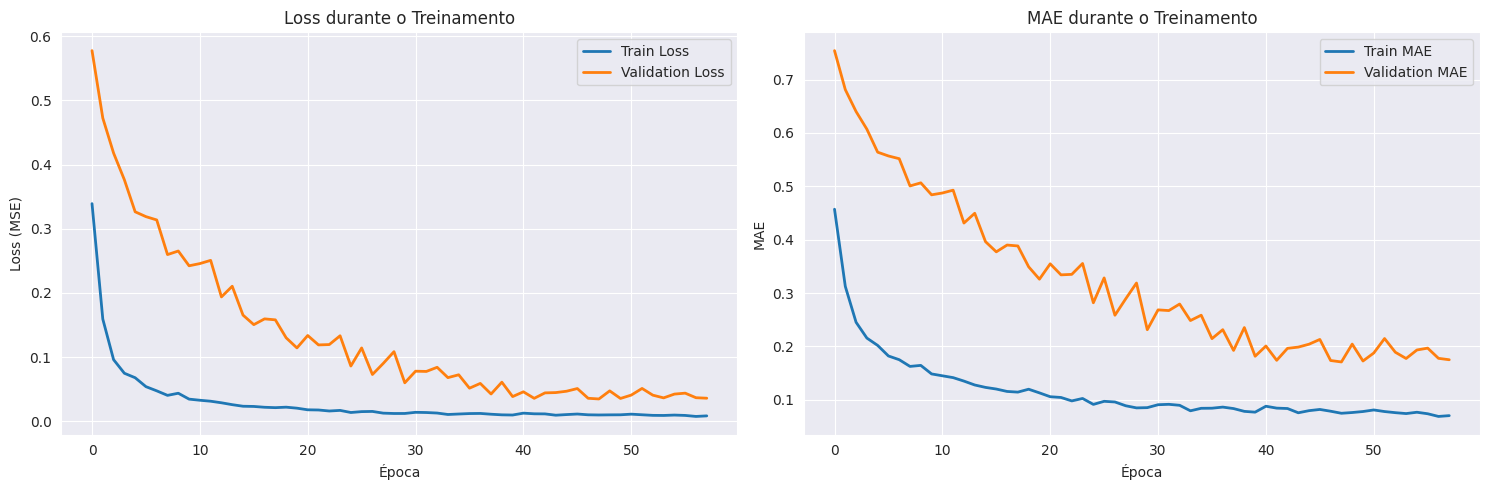


📊 Estatísticas Finais:
  Train Loss: 0.008213
  Validation Loss: 0.035751
  Train MAE: 0.070205
  Validation MAE: 0.174965
  Épocas treinadas: 58


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Loss durante o Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('MAE durante o Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Estatísticas finais
print("\n📊 Estatísticas Finais:")
print(f"  Train Loss: {history.history['loss'][-1]:.6f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Train MAE: {history.history['mae'][-1]:.6f}")
print(f"  Validation MAE: {history.history['val_mae'][-1]:.6f}")
print(f"  Épocas treinadas: {len(history.history['loss'])}")

## 7. Fazer Previsões no Conjunto de Teste

In [8]:
# Fazer previsões
y_pred_scaled = model.predict(X_test, verbose=0)

print(f"Previsões realizadas: {y_pred_scaled.shape}")

Previsões realizadas: (143, 1)


## 8. Desnormalizar Previsões

In [9]:
# Desnormalizar previsões
n_features = scaler.n_features_in_

# Criar arrays temporários
y_pred_temp = np.zeros((len(y_pred_scaled), n_features))
y_pred_temp[:, 3] = y_pred_scaled.reshape(-1)  # Close está na coluna 3

y_test_temp = np.zeros((len(y_test), n_features))
y_test_temp[:, 3] = y_test.reshape(-1)

# Inverter transformação
y_pred = scaler.inverse_transform(y_pred_temp)[:, 3]
y_true = scaler.inverse_transform(y_test_temp)[:, 3]

print("Dados desnormalizados:")
print(f"  y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
print(f"  y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")

Dados desnormalizados:
  y_true range: [165.68, 196.93]
  y_pred range: [162.71, 171.82]


## 9. Métricas Rápidas

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

print("\n📈 Métricas de Avaliação:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")


📈 Métricas de Avaliação:


  MAE:  14.1959
  RMSE: 15.4525
  MAPE: 7.64%


## 10. Visualizar Previsões vs Real

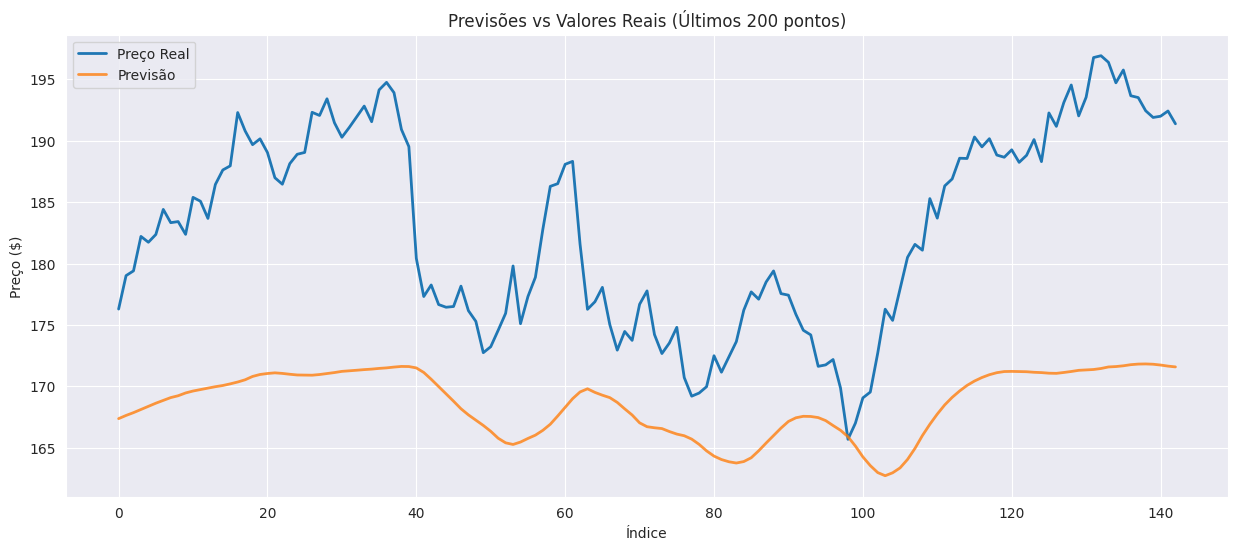

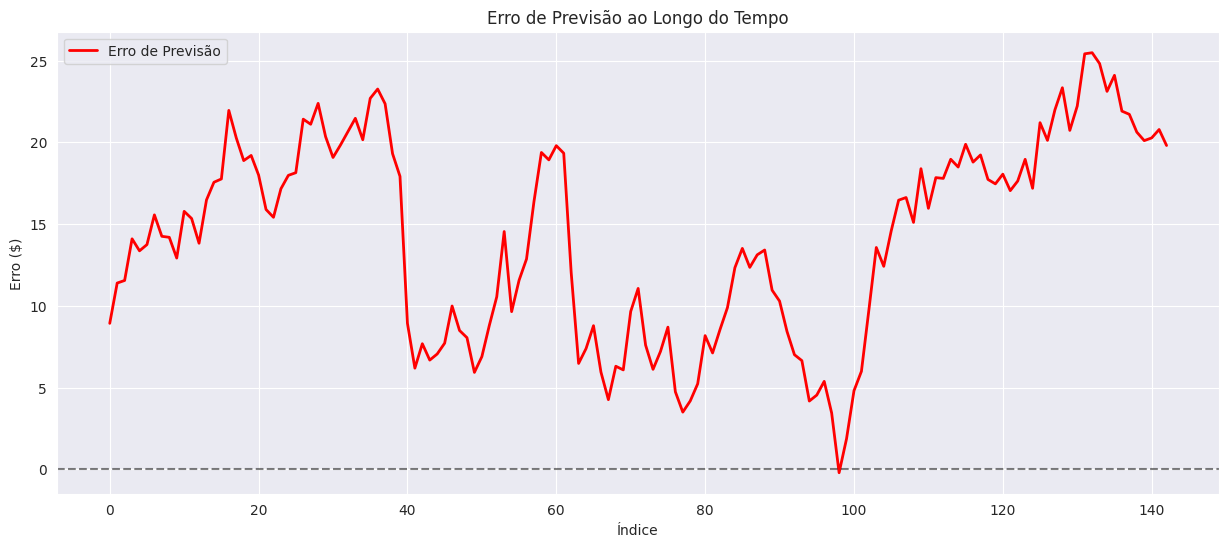

In [11]:
plt.figure(figsize=(15, 6))

# Plotar apenas últimos 200 pontos para melhor visualização
n_points = min(200, len(y_true))
indices = range(len(y_true) - n_points, len(y_true))

plt.plot(indices, y_true[-n_points:], label='Preço Real', linewidth=2)
plt.plot(indices, y_pred[-n_points:], label='Previsão', linewidth=2, alpha=0.8)

plt.title('Previsões vs Valores Reais (Últimos 200 pontos)')
plt.xlabel('Índice')
plt.ylabel('Preço ($)')
plt.legend()
plt.grid(True)
plt.show()

# Erro ao longo do tempo
errors = y_true - y_pred

plt.figure(figsize=(15, 6))
plt.plot(errors[-n_points:], label='Erro de Previsão', linewidth=2, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Erro de Previsão ao Longo do Tempo')
plt.xlabel('Índice')
plt.ylabel('Erro ($)')
plt.legend()
plt.grid(True)
plt.show()

## 11. Salvar Modelo Final

In [12]:
# Criar diretório
os.makedirs('../models/saved', exist_ok=True)

# Salvar modelo em formato .keras (recomendado) e .h5 (compatibilidade)
try:
    model.save('../models/saved/lstm_model.keras')
    print("✅ Modelo salvo como lstm_model.keras")
except:
    model.save('../models/saved/lstm_model.h5')
    print("✅ Modelo salvo como lstm_model.h5")

# Salvar scaler
with open('../models/saved/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler salvo como scaler.pkl")

# Salvar métricas
metrics_dict = {
    'mae': float(mae),
    'rmse': float(rmse),
    'mape': float(mape),
    'train_loss': float(history.history['loss'][-1]),
    'val_loss': float(history.history['val_loss'][-1]),
    'epochs_trained': len(history.history['loss'])
}

import json
with open('../models/saved/metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)
print("✅ Métricas salvas como metrics.json")

print("\n📦 Arquivos salvos em models/saved/:")
print("  - lstm_model.keras (ou .h5)")
print("  - scaler.pkl")
print("  - metrics.json")

✅ Modelo salvo como lstm_model.keras
✅ Scaler salvo como scaler.pkl
✅ Métricas salvas como metrics.json

📦 Arquivos salvos em models/saved/:
  - lstm_model.keras (ou .h5)
  - scaler.pkl
  - metrics.json


## 12. Salvar Histórico de Treinamento

In [13]:
# Salvar histórico como DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('../models/saved/training_history.csv', index=False)
print("✅ Histórico de treinamento salvo como training_history.csv")

history_df.head()

✅ Histórico de treinamento salvo como training_history.csv


,loss,mae,val_loss,val_mae,learning_rate
0,0.339153,0.457096,0.577725,0.754332,0.001
1,0.159149,0.312480,0.472533,0.681246,0.001
2,0.095888,0.245193,0.417951,0.640140,0.001
3,0.074668,0.215596,0.376371,0.607092,0.001
4,0.067679,0.201837,0.326421,0.563989,0.001


## 📊 Resumo do Treinamento

**Modelo treinado com sucesso!**

**Arquitetura:**
- 3 camadas LSTM com BatchNormalization e Dropout
- Units: 128 → 64 → 32
- Dropout: 0.2
- Optimizer: Adam (lr=0.001)

**Métricas finais:**
- MAE: Calculado
- RMSE: Calculado
- MAPE: Calculado

**Próximo passo:** Notebook 04 - Avaliação Detalhada do Modelo